# Open Wheat Detection Baseline

In [1]:
import numpy as np
import pandas as pd

import time

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import albumentations as albu
from albumentations.pytorch import ToTensor

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam,lr_scheduler

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm_notebook, tqdm

from glob import glob

import cv2

import os

In [2]:
torch.cuda.is_available()

True

In [3]:
! ls ./global-wheat-detection

sample_submission.csv  test  train  train.csv


In [4]:
TRAIN_DIR = './global-wheat-detection/train/'

`1` __Preprocess the labels:__

In [5]:
train_labels = pd.read_csv('./global-wheat-detection/train.csv')

In [6]:
train_labels.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [7]:
train_fns = glob('./global-wheat-detection/train/' + '*')

# Create a dataframe with all train images
all_train_images = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_fns])
all_train_images.columns=['image_id']

# Merge all train images with the bounding boxes dataframe
all_train_images = all_train_images.merge(train_labels, on='image_id', how='left')

# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

# split bbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

In [8]:
all_train_images['bbox_area'] = all_train_images['bbox_width'] * all_train_images['bbox_height']

In [9]:
all_train_images.head()

,image_id,width,height,bbox,source,bbox_xmin,bbox_ymin,bbox_width,bbox_height,bbox_area
0,ad62f80f2,1024.0,1024.0,"[335.0, 826.0, 148.0, 103.0]",arvalis_3,335.0,826.0,148.0,103.0,15244.0
1,ad62f80f2,1024.0,1024.0,"[330.0, 448.0, 194.0, 179.0]",arvalis_3,330.0,448.0,194.0,179.0,34726.0
2,ad62f80f2,1024.0,1024.0,"[734.0, 355.0, 287.0, 151.0]",arvalis_3,734.0,355.0,287.0,151.0,43337.0
3,ad62f80f2,1024.0,1024.0,"[71.0, 0.0, 103.0, 35.0]",arvalis_3,71.0,0.0,103.0,35.0,3605.0
4,ad62f80f2,1024.0,1024.0,"[650.0, 750.0, 79.0, 166.0]",arvalis_3,650.0,750.0,79.0,166.0,13114.0


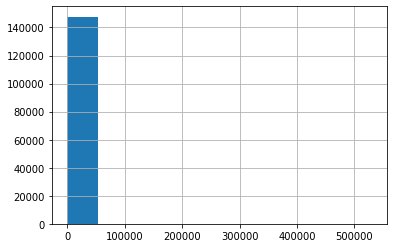

In [10]:
all_train_images.bbox_area.hist()

`2` __Remove too large and too small bounding boxes__

In [11]:
max_area_threshold = 100000
min_area_threshold = 50

In [12]:
train_labels_cleaned = all_train_images[((all_train_images.bbox_area < max_area_threshold) & (all_train_images.bbox_area > min_area_threshold)) | (all_train_images.bbox_area == 0)]

In [13]:
len(train_labels_cleaned)

147805

In [14]:
len(all_train_images)

147842

In [15]:
print("{} bounding boxes removed!".format(len(all_train_images) - len(train_labels_cleaned)))

37 bounding boxes removed!


`3` __Try to use pretrained Faster RCNN model__

https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/

In [16]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [17]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    pred = model([img]) # Pass the image to the model
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

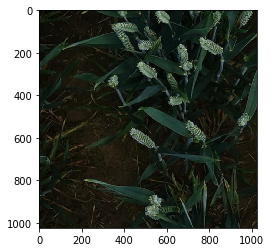

In [18]:
plt.imshow(Image.open(train_fns[1]))

In [19]:
pred_boxes, pred_class = get_prediction(train_fns[0], threshold=0.0)

/home/monster/anaconda3/envs/pytorch-conda-env/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428094786/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [20]:
pred_boxes

[[(28.674648, 0.0), (998.0564, 975.39124)]]

In [21]:
pred_class

['potted plant']

In [22]:
def plot_boxes(img, bboxes):
    fig, ax = plt.subplots()
    ax.imshow(img)
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0][0],bbox[0][1]),
                                 bbox[1][0] - bbox[0][0],
                                 bbox[1][1] - bbox[0][1],
                                 linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
    plt.show()

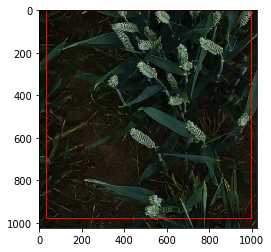

In [23]:
plot_boxes(Image.open(train_fns[1]), pred_boxes)

`4` __Train Faster RCNN model__

Examples:

https://www.kaggle.com/abhishek/training-fast-rcnn-using-torchvision

https://www.kaggle.com/arunmohan003/fasterrcnn-using-pytorch-baseline

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
device

device(type='cuda', index=0)

Setup transformations:

In [26]:
train_transforms_example = albu.Compose([
    albu.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.OneOf([albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness()], p=0.5),
    albu.CLAHE(p=1.0)], p=1.0, bbox_params=albu.BboxParams(format='coco', label_fields=['category_id']))

In [27]:
def apply_transforms(transforms, df, n_transforms=3):
    idx = np.random.randint(len(df), size=1)[0]
    
    image_id = df.iloc[idx].image_id
    bboxes = []
    for _, row in df[df.image_id == image_id].iterrows():
        bboxes.append([row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height])
        
    image = Image.open(TRAIN_DIR + image_id + '.jpg')
    
    fig, axs = plt.subplots(1, n_transforms+1, figsize=(15,7))
    
    # plot the original image
    axs[0].imshow(image)
    axs[0].set_title('original')
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)
    
    # apply transforms n_transforms times
    for i in range(n_transforms):
        params = {'image': np.asarray(image),
                  'bboxes': bboxes,
                  'category_id': [1 for j in range(len(bboxes))]}
        augmented_boxes = transforms(**params)
        bboxes_aug = augmented_boxes['bboxes']
        image_aug = augmented_boxes['image']

        # plot the augmented image and augmented bounding boxes
        axs[i+1].imshow(image_aug)
        axs[i+1].set_title('augmented_' + str(i+1))
        for bbox in bboxes_aug:
            rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
            axs[i+1].add_patch(rect)
    plt.show()

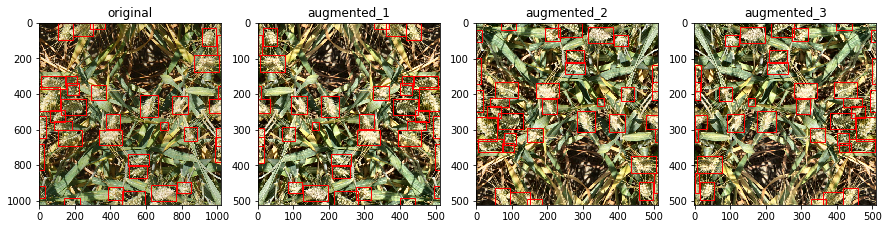

In [28]:
apply_transforms(train_transforms_example, all_train_images, n_transforms=3)

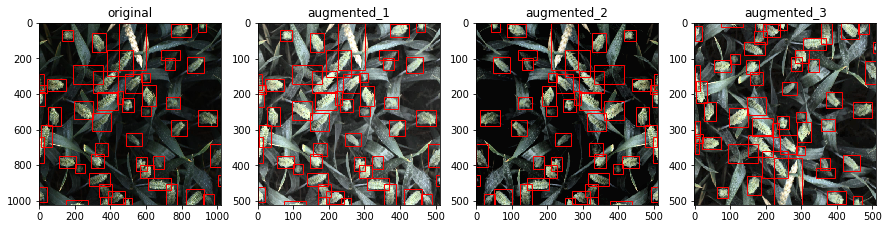

In [29]:
apply_transforms(train_transforms_example, all_train_images, n_transforms=3)

In [30]:
train_transforms = albu.Compose([
    albu.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.OneOf([albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness()], p=0.5),
    #albu.CLAHE(p=1.0),
    ToTensor()
    ], p=1.0, bbox_params=albu.BboxParams(format='pascal_voc', label_fields=['labels']))

test_transforms = albu.Compose([
    albu.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
    #albu.CLAHE(p=1.0),
    ToTensor()
    ], p=1.0, bbox_params=albu.BboxParams(format='pascal_voc', label_fields=['labels']))

Setup train and test datasets:

In [31]:
all_train_images.head(1)

,image_id,width,height,bbox,source,bbox_xmin,bbox_ymin,bbox_width,bbox_height,bbox_area
0,ad62f80f2,1024.0,1024.0,"[335.0, 826.0, 148.0, 103.0]",arvalis_3,335.0,826.0,148.0,103.0,15244.0


In [32]:
class Wheatset(Dataset):
    def __init__(self,data_frame,image_dir,phase='train'):
        super().__init__()
        self.df = data_frame
        self.image_dir = image_dir
        self.images = data_frame['image_id'].unique()
        
        if phase == 'train':
            self.transforms = train_transforms
        else:
            self.transforms = test_transforms
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx] + '.jpg'
#         image_arr = io.imread(os.path.join(self.image_dir,image))
        
        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr /= 255.0
        image_id = str(image.split('.')[0])
        point = self.df[self.df['image_id'] == image_id]
        boxes = point[['bbox_xmin', 'bbox_ymin', 'bbox_width', 'bbox_height']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((point.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        #target['image_id'] = torch.tensor(idx)
        #target['area'] = area
        #target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target, image_id

In [47]:
train_img = all_train_images[all_train_images.bbox_width > 0]

In [48]:
train_split = 0.8

image_ids = train_img['image_id'].unique()
train_ids = image_ids[0:int(train_split*len(image_ids))]
val_ids = image_ids[int(train_split*len(image_ids)):]


train_df = train_img[train_img['image_id'].isin(train_ids)]
val_df = train_img[train_img['image_id'].isin(val_ids)]

train_data = Wheatset(train_df,TRAIN_DIR,phase='train')
val_data = Wheatset(val_df,TRAIN_DIR,phase='validation')

print(f'Length of train data {len(train_data)}')
print(f'Length of validation data {len(val_data)}')

Length of train data 2698
Length of validation data 675


In [49]:
# batching
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)


In [50]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    
    fig, ax = plt.subplots(figsize=(10,10))

    bb = out[1]['boxes'].numpy()
    
    for bbox in bb:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(image)
    plt.show()

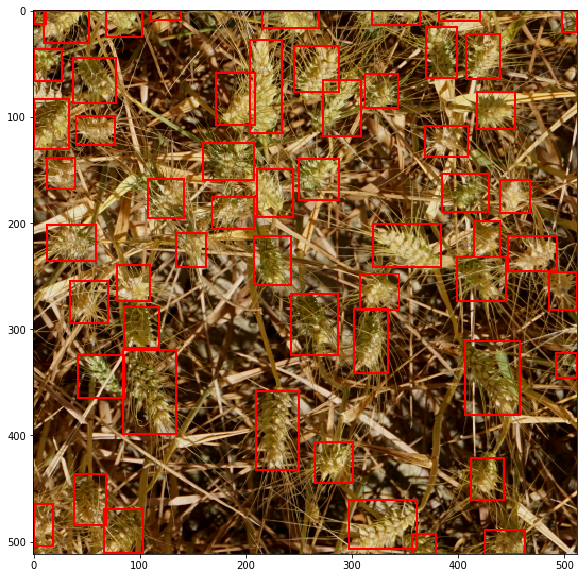

In [51]:
plot_img(train_data,101)

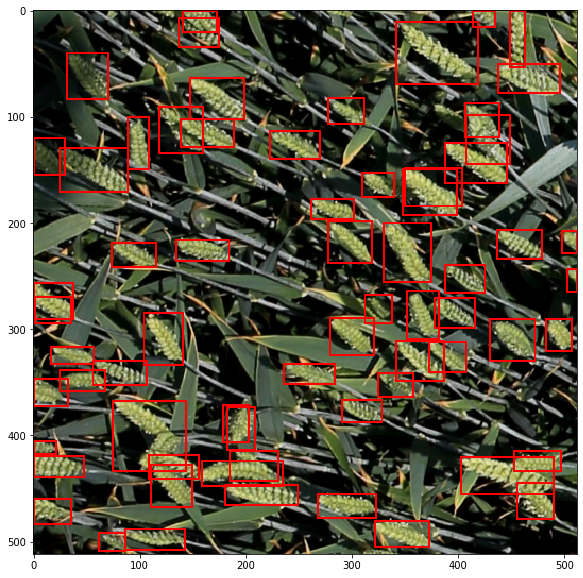

In [52]:
plot_img(train_data,22)

Train model:

In [53]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [54]:
images, targets, ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [55]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [56]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [57]:
model = model.double()

In [58]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
num_epochs = 5
train_loss_min = 0.9
total_train_loss = []


checkpoint_path = './checkpoints/chkpoint_'
best_model_path = '/checkpoints/bestmodel_may12.pt'

for epoch in range(num_epochs):
    print(f'Epoch :{epoch + 1}')
    start_time = time.time()
    train_loss = []
    model.train()
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        images = [image.double() for image in images]
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        print(targets[0]['boxes'].dtype)

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    #train_loss/len(train_data_loader.dataset)
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')
    
#     if lr_scheduler is not None:
#         lr_scheduler.step()
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'train_loss_min': epoch_train_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_train_loss <= train_loss_min:
            print('Train loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(train_loss_min,epoch_train_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            train_loss_min = epoch_train_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch :1
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64
torch.float64


In [ ]:
plt.title('train loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()